### 필요한 라이브러리들

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
# from selenium.common.exceptions import NoSuchElementException
import time
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup as bs
import pandas as pd

### 1) 제품군 선택해서 get에 해당 제품군에 대한 링크 할당
- 선택한 제품군을 Bestselling 순으로 정렬한 페이지 get
- TV : 'https://www.amazon.in/s?bbn=1389396031&rh=n%3A1389396031%2Cp_89%3ALG&dc&qid=1724652002&rnid=3837712031&ref=lp_1389396031_nr_p_89_0'
- 세탁기 : 'https://www.amazon.in/s?bbn=1380369031&rh=n%3A1380369031%2Cp_89%3ALG&dc&qid=1724689251&rnid=3837712031&ref=lp_1380369031_nr_p_89_2'
- 에어컨 : 'https://www.amazon.in/s?bbn=3474656031&rh=n%3A3474656031%2Cp_89%3ALG&dc&qid=1724689377&rnid=3837712031&ref=lp_3474656031_nr_p_89_2'
- 냉장고 : 'https://www.amazon.in/s?bbn=1380365031&rh=n%3A1380365031%2Cp_89%3ALG&dc&qid=1724689330&rnid=3837712031&ref=lp_1380365031_nr_p_89_2'

In [4]:
driver=webdriver.Chrome()
driver.get('https://www.amazon.in/s?bbn=1380365031&rh=n%3A1380365031%2Cp_89%3ALG&dc&qid=1724689330&rnid=3837712031&ref=lp_1380365031_nr_p_89_2')
driver.maximize_window()

### 2) 각각의 제품 모델에 대한 상세 페이지 접근
- url 수집 및 저장
- 최대 24개의 제품 모델

In [6]:
soup = bs(driver.page_source, 'lxml')
# url 접근 위한 select
links = soup.select('h2 > a.a-link-normal.s-underline-text.s-underline-link-text.s-link-style.a-text-normal')
# 모델명 데이터 수집 위한 select
names = soup.select('span.a-size-base-plus.a-color-base.a-text-normal')

link_list = []
for link in links :
    link_list.append("https://www.amazon.in"+link['href'])

name_list = []
for name in names :
    name_list.append(name.text)

# name_list # 모델명 확인용 
# link_list # url 확인용

### 3) 수집한 url을 활용하여 리뷰 데이터 수집
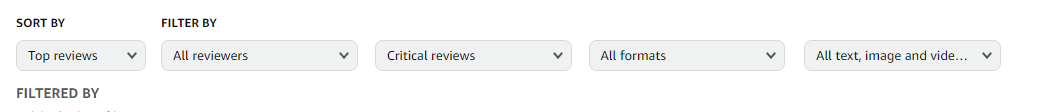
- 'See more reviews>' 버튼 클릭해서 리뷰 모아놓은 페이지 접근
- 위 이미지 조건으로 필터링 설정
- 페이지 내에 있는 리뷰에 대해 제목이랑 내용 데이터 수집
- 수집 후 Next page 버튼 클릭으로 다음 페이지 접근
- 끝페이지(최대 10페이지?)까지 데이터 수집 후 while문 종료

In [8]:
#모든 모델의 리뷰 데이터를 담아둘 데이터프레임
total_review_df = pd.DataFrame()

for link, name in zip(link_list,name_list):
    # 수집한 url마다 접근
    driver.get(link)

    # 'See more review>' 버튼으로 리뷰 모아 놓은 페이지 접근
    # 리뷰가 없는 경우 예외 처리
    try:
        time.sleep(2)
        button = driver.find_element(By.XPATH,'//*[@id="reviews-medley-footer"]/div[2]/a')
        button.click()
    except:
        continue

    # 필터링 설정
    time.sleep(1)
    # 평가 기준 정렬 박스 선택
    filter = driver.find_element(By.XPATH,'//*[@id="a-autoid-5-announce"]')
    filter.click()
    time.sleep(1)
    # 'Critical reviews' 선택
    filter_option = driver.find_element(By.XPATH,'//*[@id="star-count-dropdown_7"]')
    filter_option.click()
    time.sleep(2)
    
    # 댓글 페이지 크롤링
    time.sleep(2)
    last_url = 0
    title_list = []
    content_list = []
    date_list = []
    star_list = []

    while True :
        time.sleep(1)
        bs_star = bs(driver.page_source, 'lxml')
        current_url = driver.current_url
        
        # 다음 페이지로 넘어가는 버튼 클릭 후에도 똑같은 페이지이면 while문 종료
        if(current_url == last_url) :
            break

        last_url = driver.current_url
        
        # 리뷰 제목 수집
        title=driver.find_elements(By.CLASS_NAME,'a-size-base.a-link-normal.review-title.a-color-base.review-title-content.a-text-bold')
        for i in title:
            title_list.append(i.text)
                   
        # 리뷰 내용 수집
        content=driver.find_elements(By.CLASS_NAME,'a-size-base.review-text.review-text-content')
        for i in content:
            content_list.append(i.text)

        # 리뷰 날짜 수집
        date = driver.find_elements(By.CSS_SELECTOR, "[data-hook='review-date']")
        for i in date:
            date_list.append(i.text)

        # 별점 수집
        star = bs_star.findAll('i',{'data-hook':'review-star-rating'})
        for i in star:
            star_list.append(i.text)
        
        # 다음 페이지 버튼 클릭
        # 다음 페이지 버튼이 없는 경우는 예외 처리
        try:
            button = driver.find_element(By.CLASS_NAME,"a-last")
            button.click()
            time.sleep(2)
        except:
            break

    # 차후 모델명 인덱싱을 위한 리스트 생성
    name_list_pd = [name] * len(title_list)

    # 각 제품 모델에 대한 리뷰 데이터들을 수직 방향으로 결합
    temp_pd = pd.DataFrame({'모델명':name_list_pd,'날짜':date_list,'별점':star_list,'제목':title_list,'본문':content_list})
    total_review_df = pd.concat([total_review_df,temp_pd])

### 3) 수집한 데이터 확인

In [10]:
total_review_df.reset_index(drop=True,inplace=True)
total_review_df

,모델명,날짜,별점,제목,본문
0,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 9 December 2021,1.0 out of 5 stars,Delivered Damadged condition,Don't waste your money to buy refrigerator fro...
1,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 29 June 2024,3.0 out of 5 stars,Bended product,Fridge is bended at it's one side...may be it'...
2,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 15 June 2024,3.0 out of 5 stars,Good but egg tray was missing,Egg tray missing and the customer care person ...
3,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 24 April 2024,3.0 out of 5 stars,Go for it ...,Perfect for small family .value for money.But ...
4,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 21 April 2024,3.0 out of 5 stars,Inside space issue,Freez looking bulky from outside but inside sp...
...,...,...,...,...,...
859,LG 594 L Frost-Free Inverter Linear Wi-Fi Side...,Reviewed in India on 27 September 2023,1.0 out of 5 stars,Pathetic!! Dont waste your money.,This has been our worst purchase from LG brand...
860,LG 594 L Frost-Free Inverter Linear Wi-Fi Side...,Reviewed in India on 14 July 2022,2.0 out of 5 stars,Doesn't even keep the ice cream hard,New fridge doesn't even keep the ice cream har...
861,LG 594 L Frost-Free Inverter Linear Wi-Fi Side...,Reviewed in India on 3 March 2022,1.0 out of 5 stars,Worst refrigerator and even worse customer ser...,Stopped working before completing a year. Have...
862,LG 594 L Frost-Free Inverter Linear Wi-Fi Side...,Reviewed in India on 17 March 2021,1.0 out of 5 stars,LG is a very bad refrigerator.,You should never buy LG refrigerators.\nThey h...


In [11]:
# 상세히 확인
pd.set_option('display.max_rows',None)
total_review_df

,모델명,날짜,별점,제목,본문
0,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 9 December 2021,1.0 out of 5 stars,Delivered Damadged condition,Don't waste your money to buy refrigerator fro...
1,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 29 June 2024,3.0 out of 5 stars,Bended product,Fridge is bended at it's one side...may be it'...
2,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 15 June 2024,3.0 out of 5 stars,Good but egg tray was missing,Egg tray missing and the customer care person ...
3,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 24 April 2024,3.0 out of 5 stars,Go for it ...,Perfect for small family .value for money.But ...
4,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 21 April 2024,3.0 out of 5 stars,Inside space issue,Freez looking bulky from outside but inside sp...
5,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 21 February 2024,3.0 out of 5 stars,Average product,While power supply is stopped more than 2 to 3...
6,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 5 September 2023,3.0 out of 5 stars,GOOD PRODUCT,COMPRESSOR ALWAYS RUNNING AND SOME SMALL HUNTI...
7,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 3 November 2023,3.0 out of 5 stars,Refrigerator is okay.but don't fall in the exc...,I mainly ordered a refrigerator online due to ...
8,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 30 March 2024,2.0 out of 5 stars,Design flaw covered up by amazon,Design is pathetic but shown nice and polished...
9,LG 242 L 3 Star Smart Inverter Frost-Free Doub...,Reviewed in India on 11 June 2024,2.0 out of 5 stars,Thik h,Thik h


### 4) csv 형태로 저장

In [13]:
# total_review_df.to_csv('Amazon_LG_TV_review.csv')
# total_review_df.to_csv('Amazon_LG_Washing_Machines_review.csv')
# total_review_df.to_csv('Amazon_LG_Air_Conditioner_review.csv')
total_review_df.to_csv('Amazon_LG_Refrigerator_review.csv')